In [1]:
#%env SM_FRAMEWORK=tf.keras
#import segmentation_models as sm
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import os
import scipy
from scipy import ndimage
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns  
import sys

Libraries version:
- nibabel: 5.0.1
- pandas: 1.5.1
- numpy: 1.23.4
- matplotlib: 3.6.2
- sklearn: 1.1.3
- scipy: 1.8.1
- scikit-image: 0.19.3
- xgboost: 1.7.1
- seaborn: 0.12.1
- keras: 2.12.0
- tensorflow: 2.12.0
- segmentation-models: 1.0.1

# Read Data

In [2]:
train_ed = []
train_ed_seg = []
train_es = []
train_es_seg = []
test_ed = []
test_ed_seg = []
test_es = []
test_es_seg = []

#Training data

for dirname, _, filenames in sorted(os.walk('data/Train/')):
    for filename in filenames: 
        if filename.endswith("ED.nii") and not filename.endswith("_seg.nii"):
          #  print (os.path.join(dirname, filename))
            train_ed.append(nib.load(os.path.join(dirname, filename)))
train_ed = np.array(train_ed)

for dirname, _, filenames in sorted(os.walk('data/Train/')):
    for filename in filenames:
        if filename.endswith("ED_seg.nii") and not filename.endswith("_ED.nii"):
            train_ed_seg.append(nib.load(os.path.join(dirname, filename)))
train_ed_seg = np.array(train_ed_seg)

for dirname, _, filenames in sorted(os.walk('data/Train/')):
    for filename in filenames:
        if filename.endswith("ES.nii") and not filename.endswith("_seg.nii"):
            train_es.append(nib.load(os.path.join(dirname, filename)))
train_es = np.array(train_es)

for dirname, _, filenames in sorted(os.walk('data/Train/')):
    for filename in filenames:
        if filename.endswith("ES_seg.nii") and not filename.endswith("ES.nii"):
            train_es_seg.append(nib.load(os.path.join(dirname, filename)))
train_es_seg = np.array(train_es_seg)

#Test data
for dirname, _, filenames in sorted(os.walk('data/Test/')):
    for filename in filenames: 
        if filename.endswith("ED.nii") and not filename.endswith("_seg.nii"):
            test_ed.append(nib.load(os.path.join(dirname, filename)))
test_ed = np.array(test_ed)\

for dirname, _, filenames in sorted(os.walk('data/Test/')):
    for filename in filenames:
        if filename.endswith("ED_seg.nii") and not filename.endswith("_ED.nii"):
            test_ed_seg.append(nib.load(os.path.join(dirname, filename)))
test_ed_seg = np.array(test_ed_seg)

for dirname, _, filenames in sorted(os.walk('data/Test/')):
    for filename in filenames:
        if filename.endswith("ES.nii") and not filename.endswith("_seg.nii"):
            test_es.append(nib.load(os.path.join(dirname, filename)))
test_es = np.array(test_es)

for dirname, _, filenames in sorted(os.walk('data/Test/')):
    for filename in filenames:
        if filename.endswith("ES_seg.nii") and not filename.endswith("ES.nii"):
            test_es_seg.append(nib.load(os.path.join(dirname, filename)))
test_es_seg = np.array(test_es_seg)

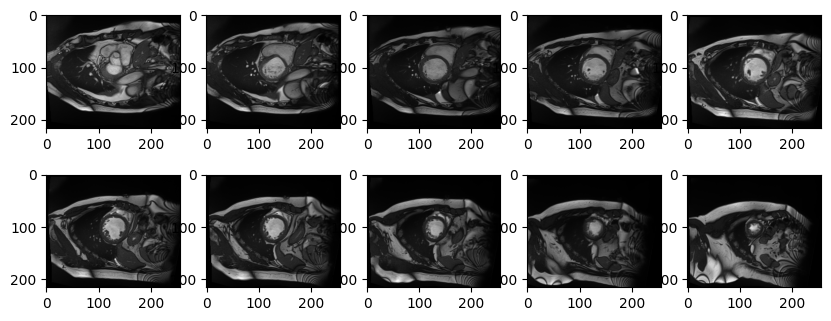

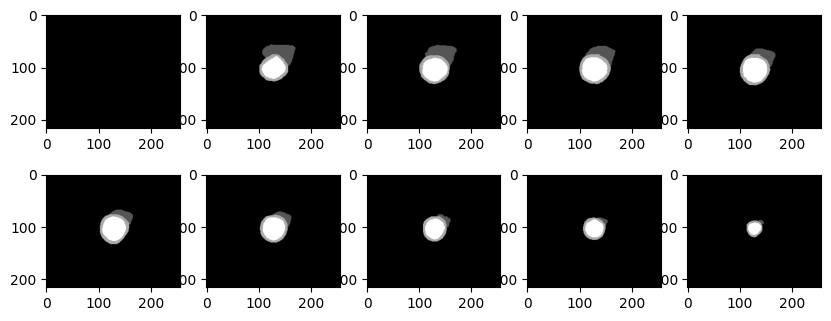

In [3]:
#Plotting data in order to visualize it
a = train_ed[0].get_fdata()
for i in range(a.shape[2]):
    plt.subplot(5, 5,i + 1)
    plt.imshow(a[:,:,0 + i], cmap='gray')
    plt.gcf().set_size_inches(10, 10)
plt.show()
a = train_ed_seg[0].get_fdata()
for i in range(a.shape[2]):
    plt.subplot(5, 5,i + 1)
    plt.imshow(a[:,:,0 + i], cmap='gray')
    plt.gcf().set_size_inches(10, 10)

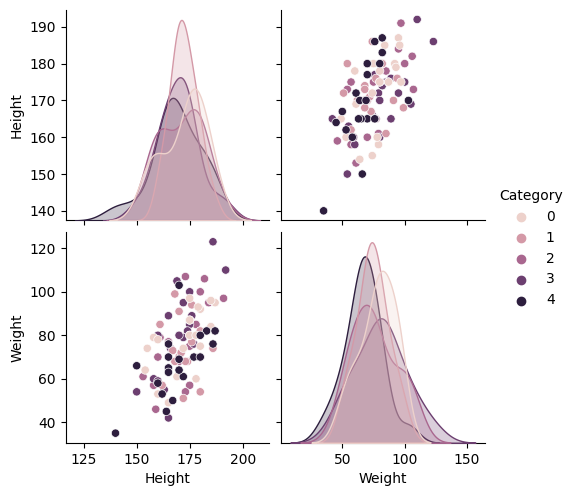

In [4]:
#Get metadata and plot pairplot of it
meta_train = pd.read_csv('data/metaDataTrain.csv')
meta_test = pd.read_csv('data/metaDataTest.csv')
sns.pairplot(meta_train.drop(['Id'], axis=1), hue='Category')

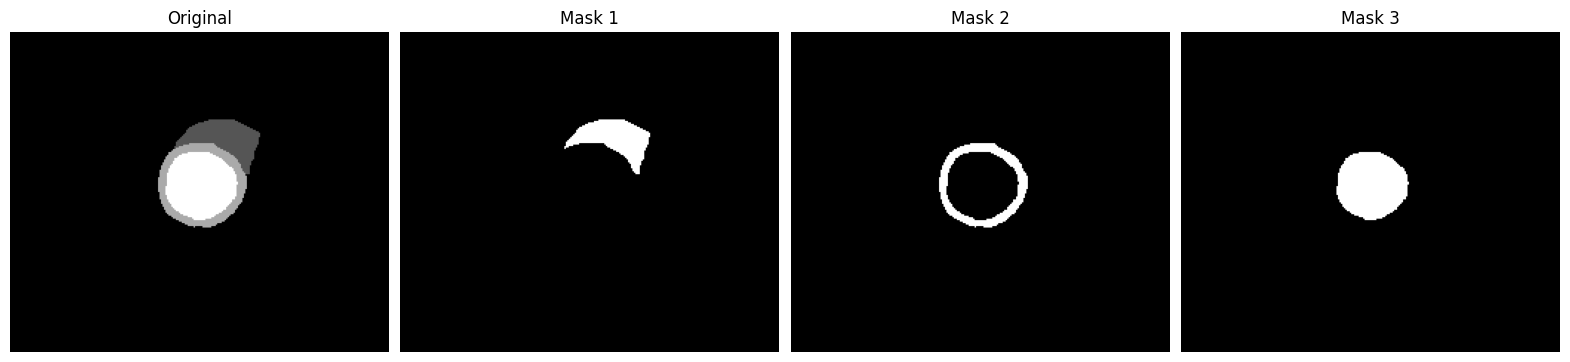

In [5]:
#Plot an example of segmented image
img = train_ed_seg[0].get_fdata()
ax, fig = plt.subplots(1,4, figsize=(20,20))
fig[0].imshow(img[:,:,3], cmap='gray')
fig[0].set_title('Original')
fig[0].axis('off')
for i in range(1,4):
    fig[i].imshow(img[:,:,3] == i, cmap='gray')
    fig[i].set_title(f'Mask {i}')
    fig[i].axis('off')
plt.subplots_adjust(wspace=0.03, hspace=0.1)

1 = RV

2 = Myocardium

3 = LV

# Segmentation

In the following cell, we used the function "fill_holes" in order to segment the LV using the MYO mask

In [6]:
def segment (img):
    #Define myo mask, the hole to be filled and the final segmentation
    myo = img == 2
    seg = np.zeros(myo.shape)
    hol = np.zeros(myo.shape)
    
    #Fill the hole in the mask
    for i in range (myo.shape[-1]):
        hol[:,:,i] = ndimage.binary_fill_holes(myo[:,:,i])
        seg[:,:,i] = hol[:,:,i] - myo[:,:,i]

    #Return the final segmentation of the LV added to the RV and MYO
    return np.where(seg==1, 3, 0) + np.where(img == 1, 1, 0) + np.where(img == 2, 2, 0)

Next, we test the function in the train_ed set, passing the images without the LV mask and comparing the result of the function with the ground truth.

In [7]:
k = np.copy(train_ed_seg)
rv = np.zeros(k.shape)

#Replace values 3 for values 0 in k
for i, image in enumerate(k):
    for j in range(image.shape[2]):
        k[i].get_fdata()[:,:,j] = np.where(image.get_fdata()[:,:,j] == 3, 0, image.get_fdata()[:,:,j])
for i, image in enumerate(train_ed_seg):
    k[i].get_fdata()[:] = segment(k[i].get_fdata())

#Calculate jaccard score of each channel of each image in train_es_seg
jaccard_train_es_seg = []
for i, image in enumerate(train_es_seg):
    jaccard_train_es_seg.append([])
    for j in range(image.shape[2]):
        jaccard_train_es_seg[i].append(jaccard_score(train_es_seg[i].get_fdata()[:,:,j].flatten(), k[i].get_fdata()[:,:,j].flatten(), average='micro'))

#Compute mean jaccard score of each image in train_es_seg
buf = []
for i in jaccard_train_es_seg:
    buf.append(np.mean(i))

print ('Mean Jaccard Score between ground truth and segmentation for each slice of each image in train_es' , np.mean(buf))



Mean Jaccard Score between ground truth and segmentation for each slice of each image in train_es 0.962465043717494


Therefore, we can see that the score is high enough to be used to extract the features. Since there are many slices in each image, the majority of the results are pratically identical.

In [8]:
#Use the function for each channel of each image in the test images and segment it
for i, image in enumerate(test_ed_seg):
    test_ed_seg[i].get_fdata()[:] = segment(image.get_fdata())

for i, image in enumerate(test_es_seg):
    test_es_seg[i].get_fdata()[:] = segment(image.get_fdata())

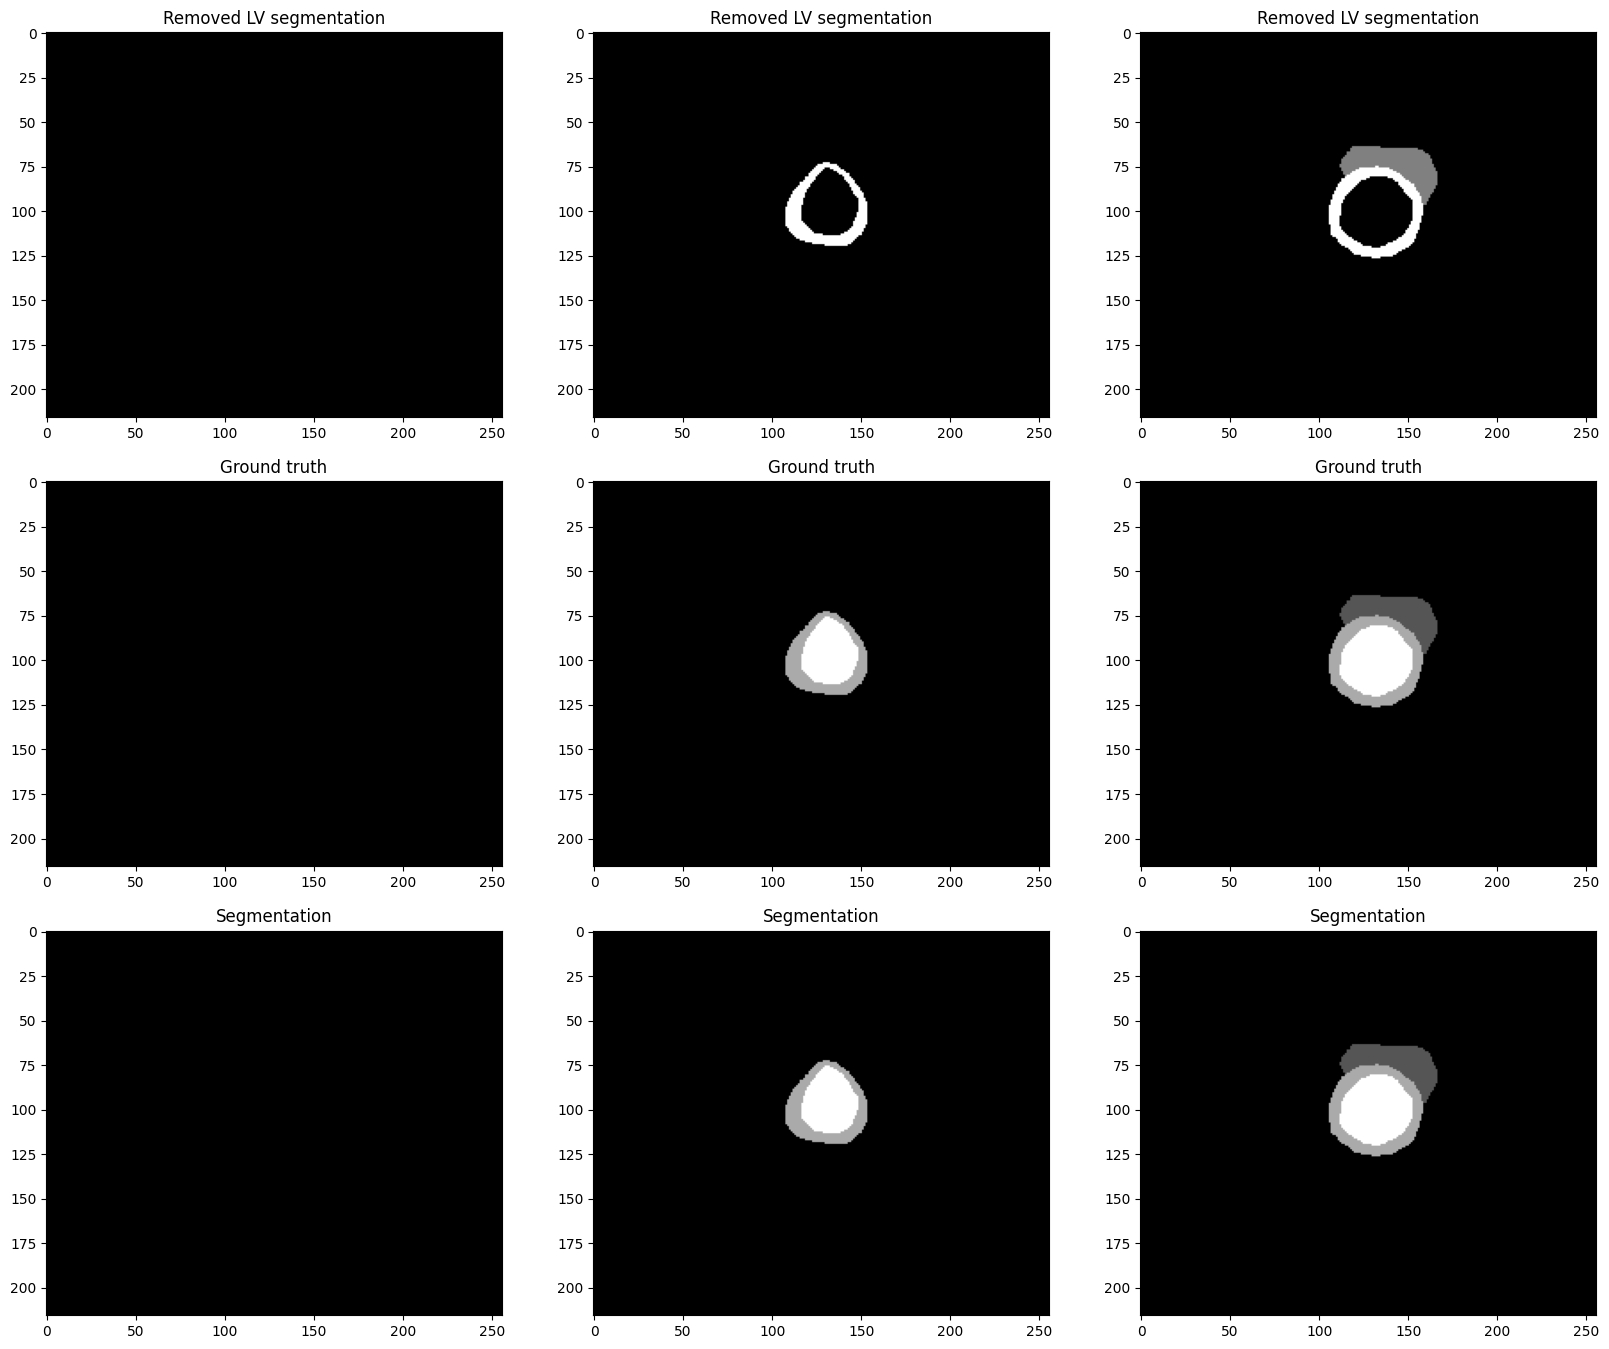

Jaccard score for first slice: 1.0
Jaccard score for second slice: 1.0
Jaccard score for third slice: 1.0


In [9]:
k = np.copy(train_es_seg)[0]
ex = np.where(k.get_fdata() == 3, 0, k.get_fdata())

seg = segment(ex)

#Plot example of segmentation

ax, fig = plt.subplots(3, 3, figsize=(20,20))

fig[0,0].imshow(ex[:,:,0], cmap='gray')
fig[0,0].set_title('Removed LV segmentation')
fig[0,1].imshow(ex[:,:,1], cmap='gray')
fig[0,1].set_title('Removed LV segmentation')
fig[0,2].imshow(ex[:,:,2], cmap='gray')
fig[0,2].set_title('Removed LV segmentation')

fig[1,0].imshow(k.get_fdata()[:,:,0], cmap='gray')
fig[1,0].set_title('Ground truth')
fig[1,1].imshow(k.get_fdata()[:,:,1], cmap='gray')
fig[1,1].set_title('Ground truth')
fig[1,2].imshow(k.get_fdata()[:,:,2], cmap='gray')
fig[1,2].set_title('Ground truth')

fig[2,0].imshow(seg[:,:,0], cmap='gray')
fig[2,0].set_title('Segmentation')
fig[2,1].imshow(seg[:,:,1], cmap='gray')
fig[2,1].set_title('Segmentation')
fig[2,2].imshow(seg[:,:,2], cmap='gray')
fig[2,2].set_title('Segmentation')

plt.subplots_adjust( hspace=-0.3)
plt.show()

#print jaccard scores
print('Jaccard score for first slice:', jaccard_score(k.get_fdata()[:,:,0].flatten(), seg[:,:,0].flatten(), average='micro'))
print('Jaccard score for second slice:', jaccard_score(k.get_fdata()[:,:,1].flatten(), seg[:,:,1].flatten(), average='micro'))
print('Jaccard score for third slice:', jaccard_score(k.get_fdata()[:,:,2].flatten(), seg[:,:,2].flatten(), average='micro'))

As we can see in some examples, this method sucessfully segments the LV, the Jaccard score is 1 and we can see that the images are identical.

# Feature Extraction

In [10]:
#Calculate Volume of specific mask for a specific image using nibabel
def volume2(mask_image, spacing):
    vol = np.sum(mask_image) * np.prod(spacing)
    return vol

In [11]:
#Get spacings on the header of each image
spacings_train_ed = []
spacings_train_es = []
spacings_test_ed = []
spacings_test_es = []
for i in range(len(train_ed)):
    spacings_train_ed.append(train_ed[i].header.get_zooms())
    spacings_train_es.append(train_es[i].header.get_zooms())
for i in range(len(test_ed)):
    spacings_test_ed.append(test_ed[i].header.get_zooms())
    spacings_test_es.append(test_es[i].header.get_zooms())

In [12]:
#Define function to calculate volume of each mask for each image
def process_images(images, spacings, vol_masks, state):
    for i, img in enumerate(images):
        for j in range(1, 4):
            mask = (img.get_fdata() == j).astype(int)
            if j == 1:
                vol_masks['RV_' + state].append(volume2(mask, spacings[i]))
            elif j == 2:
                vol_masks['MYO_' + state].append(volume2(mask, spacings[i]))
            elif j == 3:
                vol_masks[f'LV_' + state].append(volume2(mask, spacings[i]))

In [13]:
#Calculate the volumes of each mask for each image
vol_masks_train = {'RV_ED':[], 'MYO_ED':[], 'LV_ED':[], 'RV_ES':[], 'MYO_ES':[], 'LV_ES':[]}
vol_masks_test = {'RV_ED':[], 'MYO_ED':[], 'LV_ED':[], 'RV_ES':[], 'MYO_ES':[] , 'LV_ES':[]}

# Train ED
process_images(train_ed_seg, spacings_train_ed, vol_masks_train, 'ED')

# Test ED
process_images(test_ed_seg, spacings_test_ed, vol_masks_test, 'ED')

# Train ES
process_images(train_es_seg, spacings_train_es, vol_masks_train, 'ES')

# Test ES
process_images(test_es_seg, spacings_test_es, vol_masks_test, 'ES')

vol_masks_train = pd.DataFrame(vol_masks_train)
vol_masks_test = pd.DataFrame(vol_masks_test)

In [14]:
#Concatenate volumes with Height and Weight
data_train = pd.concat([meta_train, pd.DataFrame(vol_masks_train)], axis=1)
data_test = pd.concat([meta_test, pd.DataFrame(vol_masks_test)], axis=1)

In [15]:
#Normalize volumes using Mosteller formula
factor = np.sqrt((data_train['Height'] * data_train['Weight']/3600))

data_train['RV_ED'] =  data_train['RV_ED']/ factor
data_train['LV_ED'] =  data_train['LV_ED']/ factor
data_train['LV_ES'] =  data_train['LV_ES']/ factor
data_train['RV_ES'] =  data_train['RV_ES']/ factor
data_train['MYO_ED'] = data_train['MYO_ED']/factor
data_train['MYO_ES'] = data_train['MYO_ES']/factor

factor2 = np.sqrt((data_test['Height'] * data_test['Weight']/3600))
data_test['RV_ED'] =  data_test['RV_ED']/ factor2
data_test['LV_ED'] =  data_test['LV_ED']/ factor2
data_test['LV_ES'] =  data_test['LV_ES']/ factor2
data_test['RV_ES'] =  data_test['RV_ES']/ factor2
data_test['MYO_ED'] = data_test['MYO_ED']/factor2
data_test['MYO_ES'] = data_test['MYO_ES']/factor2

In [16]:
#Add columns to  data with the 14 features from Wolternik et al (Ejection fractions and Ratios)
data_train['EJ_LV'] = (data_train['LV_ED'] - data_train['LV_ES']) / data_train['LV_ED']
data_train['EJ_RV'] = (data_train['RV_ED'] - data_train['RV_ES']) / data_train['RV_ED']
data_train['R_RVLV_ED'] = data_train['RV_ED'] / data_train['LV_ED']
data_train['R_RVLV_ES'] = data_train['RV_ES'] / data_train['LV_ES']
data_train['R_MYOLV_ED'] = data_train['MYO_ED'] / data_train['LV_ED']
data_train['R_MYOLV_ES'] = data_train['MYO_ES'] / data_train['LV_ES']

data_test['EJ_LV'] = (data_test['LV_ED'] - data_test['LV_ES']) / data_test['LV_ED']
data_test['EJ_RV'] = (data_test['RV_ED'] - data_test['RV_ES']) / data_test['RV_ED']
data_test['R_RVLV_ED'] = data_test['RV_ED'] / data_test['LV_ED']
data_test['R_RVLV_ES'] = data_test['RV_ES'] / data_test['LV_ES']
data_test['R_MYOLV_ED'] = data_test['MYO_ED'] / data_test['LV_ED']
data_test['R_MYOLV_ES'] = data_test['MYO_ES'] / data_test['LV_ES']

y_train = data_train['Category']
X_train = data_train.drop(['Category', 'Id'], axis=1)

X_test = data_test.drop('Id', axis=1)

In [17]:
def myocardial_thickness(myocardial_mask, pixel_spacing, slices_to_skip=(0,0), myo_label=2):
    """
    Calculate myocardial thickness of mid-slices, excluding a few apex and basal slices
    since myocardium is difficult to identify
    """
    holes_filles = np.zeros(myocardial_mask.shape)
    interior_circle = np.zeros(myocardial_mask.shape)

    cinterior_circle_edge=np.zeros(myocardial_mask.shape)
    cexterior_circle_edge=np.zeros(myocardial_mask.shape)

    overall_avg_thickness= []
    overall_std_thickness= []
    for i in range(slices_to_skip[0], myocardial_mask.shape[2]-slices_to_skip[1]):
        #Get the mask, fill the hole and computer interior circle
        myocardial_slice = myocardial_mask[:, :, i] == myo_label
        holes_filles[:, :, i] = ndimage.binary_fill_holes(myocardial_slice)
        interior_circle[:, :, i] = holes_filles[:, :, i] - myocardial_slice

        #Compute internal and external edges with canny function
        cinterior_circle_edge[:, :, i] = feature.canny(interior_circle[:, :, i])
        cexterior_circle_edge[:, :, i] = feature.canny(holes_filles[:, :, i])

        x_in, y_in = np.where(cinterior_circle_edge[:, :, i] != 0)
        number_of_interior_points = len(x_in)

        x_ex,y_ex=np.where(cexterior_circle_edge[:, :, i] != 0)
        number_of_exterior_points=len(x_ex)

        if len(x_ex) and len(x_in) != 0:
            total_distance_in_slice=[]
            for z in range(number_of_interior_points):
                #Compute distance between each interior point and each exterior point
                distance=[]
                for k in range(number_of_exterior_points):
                    a  = [x_in[z], y_in[z]]
                    a=np.array(a)

                    b  = [x_ex[k], y_ex[k]]
                    b=np.array(b)

                    dst = scipy.spatial.distance.euclidean(a, b)

                    distance = np.append(distance, dst)

                distance = np.array(distance)
                min_dist = np.min(distance)
                total_distance_in_slice = np.append(total_distance_in_slice,min_dist)
                total_distance_in_slice = np.array(total_distance_in_slice)
            
            #Compute average distances and std
            average_distance_in_slice = np.mean(total_distance_in_slice)*pixel_spacing[0]
            overall_avg_thickness = np.append(overall_avg_thickness, average_distance_in_slice)


            std_distance_in_slice = np.std(total_distance_in_slice)*pixel_spacing[0]
            overall_std_thickness = np.append(overall_std_thickness, std_distance_in_slice)

    return (overall_avg_thickness, overall_std_thickness)


The following cell calculates the thickness of the myocardium, it can take some time to run (arround 6 minutes in my computer)

In [18]:
#Calculate thickness for each image
myo_thickness_train_ed = []
myo_thickness_train_es = []
myo_thickness__test_ed = []
myo_thickness_test_es = []
for i in range (len(train_ed_seg)):
    c = train_ed_seg[i].get_fdata()
    c = c==2
    c = c.astype(int)
    c2 = train_es_seg[i].get_fdata()
    c2 = c2==2
    c2 = c2.astype(int)

    myo_thickness_train_ed.append(myocardial_thickness(c, spacings_train_ed[i], slices_to_skip=(1,1), myo_label=1))
    myo_thickness_train_es.append(myocardial_thickness(c2, spacings_train_es[i], slices_to_skip=(1,1), myo_label=1))

for i in range (len(test_ed_seg)):
    c = test_ed_seg[i].get_fdata()
    c = c==2
    c = c.astype(int)
    c2 = test_es_seg[i].get_fdata()
    c2 = c2==2
    c2 = c2.astype(int)
    myo_thickness__test_ed.append(myocardial_thickness(c, spacings_test_ed[i], slices_to_skip=(1,1), myo_label=1))
    myo_thickness_test_es.append(myocardial_thickness(c2, spacings_test_es[i], slices_to_skip=(1,1), myo_label=1))
    


In [19]:
#Calculate mean, std, max and min values of thickness for each image

data_train['ED_MYO_T_MEAN'] = [np.mean(myo_thickness_train_ed[i][0]) for i in range(len(myo_thickness_train_ed))]
data_train['ED_MYO_T_STD'] = [np.mean(myo_thickness_train_ed[i][1]) for i in range(len(myo_thickness_train_ed))]
data_train['ED_MYO_T_MAX'] = [np.max(myo_thickness_train_ed[i][0]) for i in range(len(myo_thickness_train_ed))]
data_train['ED_MYO_T_MIN'] = [np.min(myo_thickness_train_ed[i][0]) for i in range(len(myo_thickness_train_ed))]

data_train['ES_MYO_T_MEAN'] = [np.mean(myo_thickness_train_es[i][0]) for i in range(len(myo_thickness_train_es))]
data_train['ES_MYO_T_STD'] = [np.mean(myo_thickness_train_es[i][1]) for i in range(len(myo_thickness_train_es))]
data_train['ES_MYO_T_MAX'] = [np.max(myo_thickness_train_es[i][0]) for i in range(len(myo_thickness_train_es))]
data_train['ES_MYO_T_MIN'] = [np.min(myo_thickness_train_es[i][0]) for i in range(len(myo_thickness_train_es))]

data_test['ED_MYO_T_MEAN'] = [np.mean(myo_thickness__test_ed[i][0]) for i in range(len(myo_thickness__test_ed))]
data_test['ED_MYO_T_STD'] = [np.mean(myo_thickness__test_ed[i][1]) for i in range(len(myo_thickness__test_ed))]
data_test['ED_MYO_T_MAX'] = [np.max(myo_thickness__test_ed[i][0]) for i in range(len(myo_thickness__test_ed))]
data_test['ED_MYO_T_MIN'] = [np.min(myo_thickness__test_ed[i][0]) for i in range(len(myo_thickness__test_ed))]

data_test['ES_MYO_T_MEAN'] = [np.mean(myo_thickness_test_es[i][0]) for i in range(len(myo_thickness_test_es))]
data_test['ES_MYO_T_STD'] = [np.mean(myo_thickness_test_es[i][1]) for i in range(len(myo_thickness_test_es))]
data_test['ES_MYO_T_MAX'] = [np.max(myo_thickness_test_es[i][0]) for i in range(len(myo_thickness_test_es))]
data_test['ES_MYO_T_MIN'] = [np.min(myo_thickness_test_es[i][0]) for i in range(len(myo_thickness_test_es))]

In [20]:
y_train = data_train['Category']
X_train = data_train.drop(['Category', 'Id'], axis=1)

X_test = data_test.drop('Id', axis=1)

In [21]:
X_train

,Height,Weight,RV_ED,MYO_ED,LV_ED,RV_ES,MYO_ES,LV_ES,EJ_LV,EJ_RV,...,R_MYOLV_ED,R_MYOLV_ES,ED_MYO_T_MEAN,ED_MYO_T_STD,ED_MYO_T_MAX,ED_MYO_T_MIN,ES_MYO_T_MEAN,ES_MYO_T_STD,ES_MYO_T_MAX,ES_MYO_T_MIN
0,184.0,95.0,63408.040762,74542.949195,134106.399682,27022.927034,88525.291925,102385.760035,0.236533,0.573825,...,0.555849,0.864625,7.751290,1.163030,8.373337,6.613909,9.872333,1.534835,10.728019,8.429434
1,160.0,70.0,53537.950152,90957.289421,150662.913166,16341.155807,109174.181011,106757.978985,0.291412,0.694774,...,0.603714,1.022633,7.265907,1.663262,8.753109,5.240348,10.111099,1.657941,13.017211,8.565319
2,165.0,77.0,102381.136027,102121.219459,147294.718929,92933.168790,107033.642589,128333.805314,0.128728,0.092282,...,0.693312,0.834025,8.751873,1.291190,9.861484,7.941831,9.654191,1.613129,10.335495,9.218960
3,159.0,46.0,74552.188959,118181.939648,183003.658210,59313.905129,122745.556492,158887.303681,0.131781,0.204398,...,0.645790,0.772532,8.093383,1.250296,8.886948,6.395734,8.782069,1.641273,9.996516,7.596400
4,165.0,77.0,90739.472958,107203.108191,154793.961700,39685.361143,123635.163561,119287.669091,0.229378,0.562645,...,0.692554,1.036445,8.891034,1.474051,10.084796,7.450290,11.399780,1.785121,12.867319,9.003270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,186.0,76.0,143366.827020,59027.095472,76838.103583,109852.411036,58062.600448,37801.060535,0.508043,0.233767,...,0.768201,1.536005,7.205764,1.610693,8.791097,5.749782,9.865868,1.912807,11.993945,6.994421
96,187.0,82.0,101188.328102,45309.481374,60266.734768,62551.425865,53466.042112,24063.989401,0.600709,0.381832,...,0.751816,2.221828,6.545060,1.344900,8.915571,4.949992,11.144930,1.337814,14.248055,8.922228
97,167.0,50.0,108115.069765,61475.184858,61618.818467,106042.641971,67087.155171,27044.156757,0.561106,0.019169,...,0.997669,2.480653,8.413212,1.337465,9.952443,6.135052,12.096625,2.356327,13.159913,10.296209
98,180.0,80.0,100182.867127,46292.823220,70200.551279,68319.182882,46117.441421,37029.475436,0.472519,0.318055,...,0.659437,1.245425,6.399018,1.271730,7.313388,4.947622,8.650878,1.289159,11.248501,7.161446


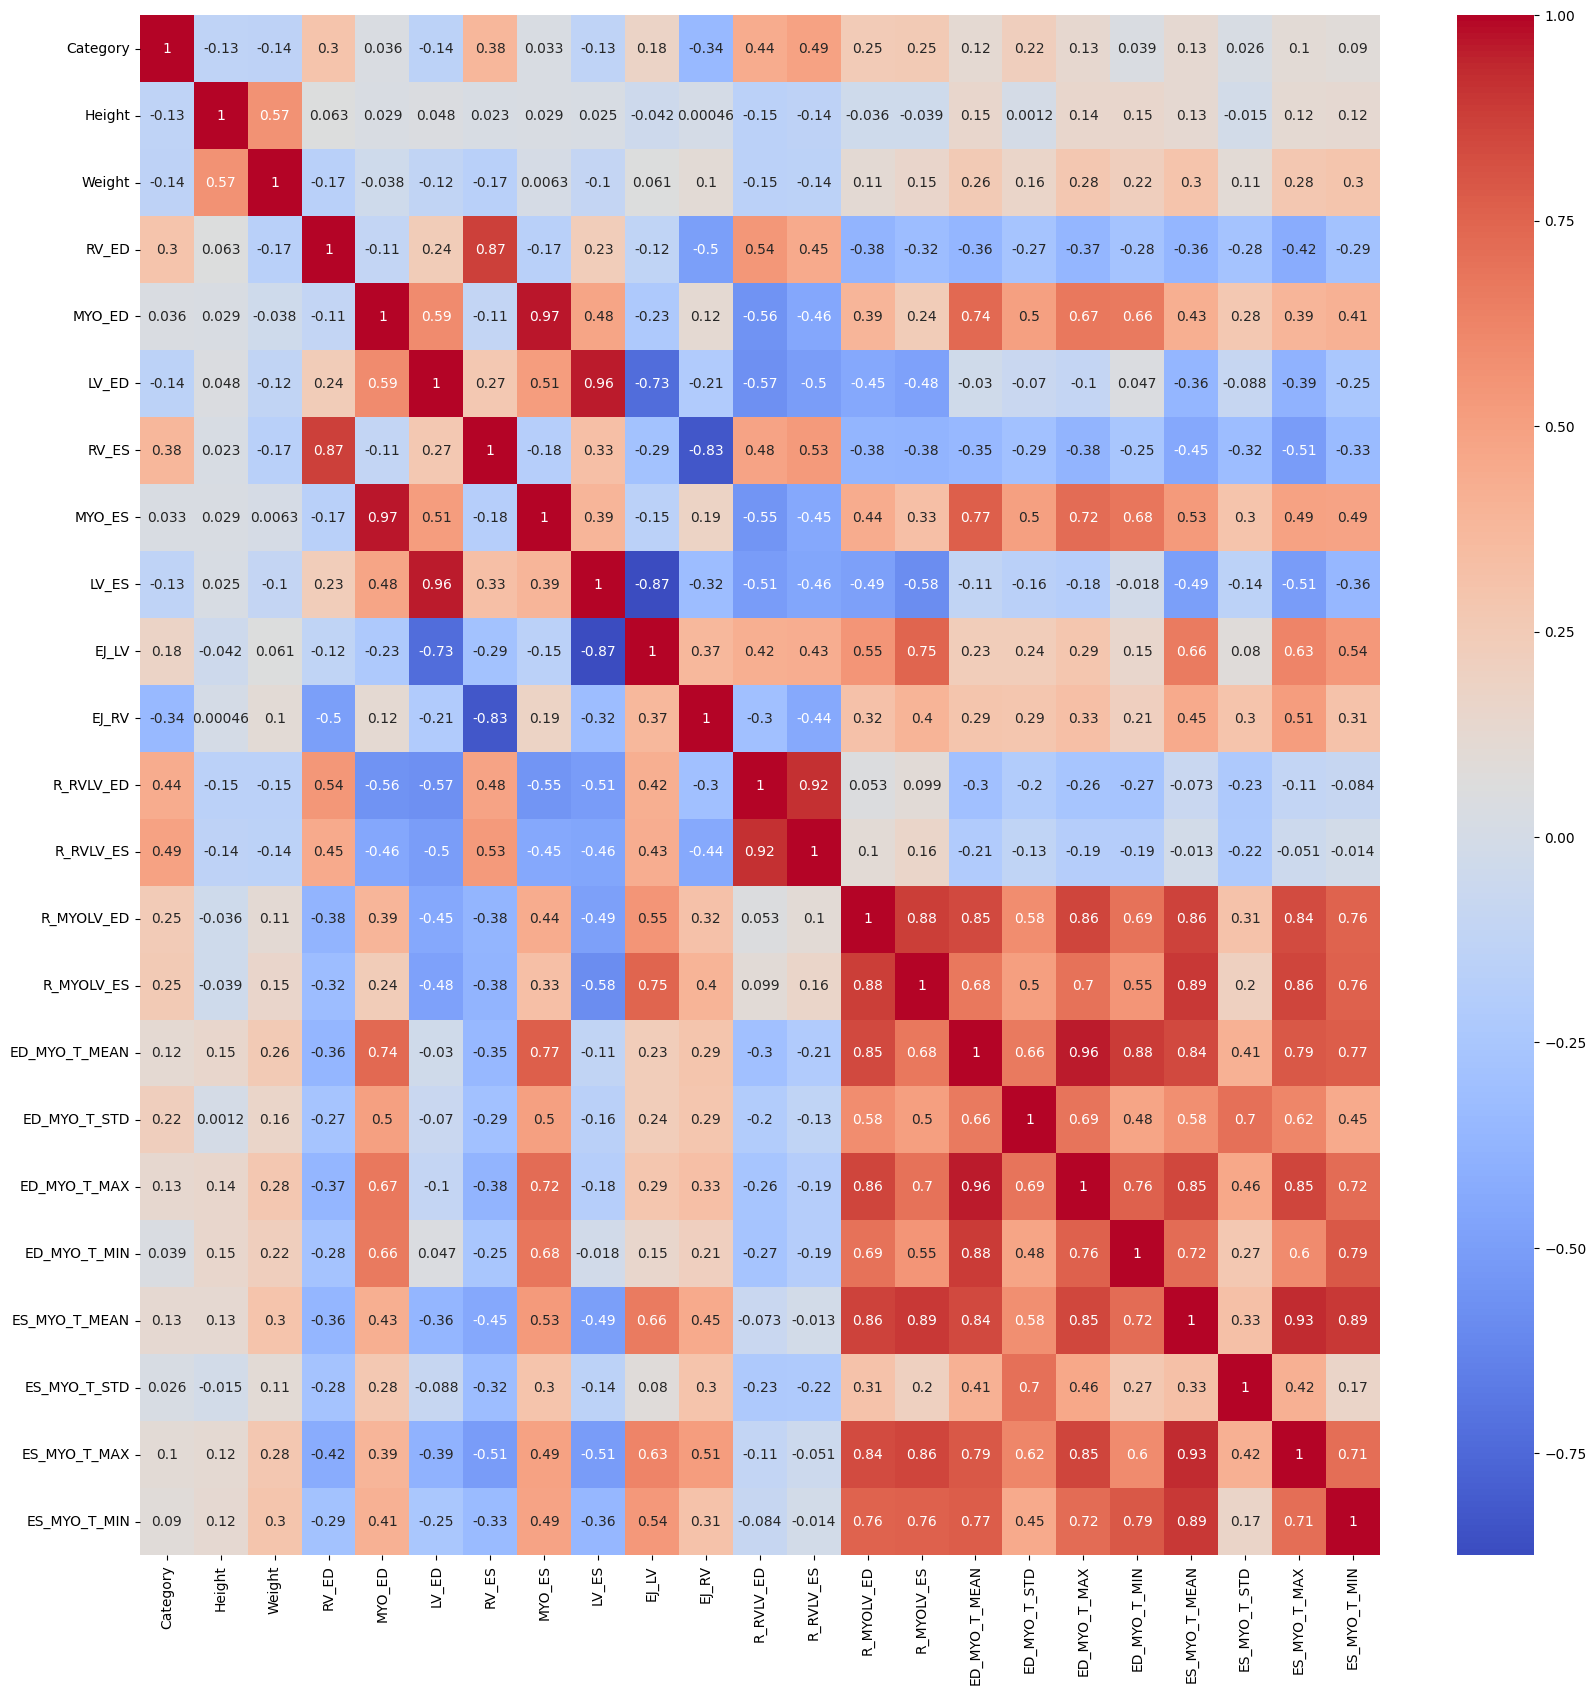

In [22]:
#plot correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(data_train.drop(['Id'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()

# Classification

In [23]:
model = RandomForestClassifier(n_estimators=1000, random_state=6)
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
print(results.mean())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

0.8800000000000001


In [24]:
#save to csv
submission = pd.DataFrame({'Id': data_test['Id'], 'Category': y_pred})
submission.to_csv('submission_2.csv', index=False)

# Other Experiments

In [44]:
model = XGBClassifier( n_estimators=1000, learning_rate=0.01)
#model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#kfold
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
print(results.mean())


0.8


In [26]:
model = MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200), max_iter=1000)
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
print(results.mean())

0.82


In [27]:
#creat a random search for the hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = [ 'sqrt', 'log2', None]
criterion = ['gini', 'entropy', 'log_loss']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_state = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17 ,18, 19, 20, 21, 21, 22, 23, 24, 25]

random_grid = {'n_estimators': n_estimators,
               # 'max_features': max_features,       
                'max_depth': max_depth,
              #  'min_samples_split': min_samples_split,
              #  'min_samples_leaf': min_samples_leaf,
 #               'bootstrap': bootstrap,
                'random_state': random_state}
    #            'criterion': criterion}

print(random_grid)

model = RandomForestClassifier()
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 300, cv = 10, verbose=0, n_jobs = -1, scoring='accuracy')
model_random.fit(X_train, y_train)
print(model_random.best_params_)

{'n_estimators': [10, 64, 118, 173, 227, 282, 336, 391, 445, 500], 'max_depth': [1, 12, 23, 34, 45, 56, 67, 78, 89, 100, None], 'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 22, 23, 24, 25]}
{'random_state': 1, 'n_estimators': 227, 'max_depth': 45}


In [38]:
#get accuracy of model with best params in the random search
a = model_random.cv_results_['mean_test_score']
#eliminate all nan values from a
a = a[~np.isnan(a)]